<a href="https://colab.research.google.com/github/Samin-Sadaf7/Image_works/blob/main/EfficientDet_traffic_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [3]:
#zip_path = '/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/train/train-20240716T142031Z-001.zip'
#extract_to ='/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/train_main'
#extract_zip(zip_path, extract_to)

In [4]:
!pip install --quiet albumentations
!pip install --quiet effdet
!pip install --quiet ensemble-boxes
!pip install --quiet fastcore
!pip install --quiet pytorch-lightning
!pip install --quiet timm
!pip install --quiet torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 45.1 MB/s eta 0:00:00


In [5]:
!pip install pytorch_lightning==1.6.0

Requested pytorch_lightning==1.6.0 from https://files.pythonhosted.org/packages/09/18/cee67f4849dea9a29b7af7cdf582246bcba9eaa73d9443e138a4172ec786/pytorch_lightning-1.6.0-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    torch (>=1.8.*)
           ~~~~~~^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement pytorch_lightning==1.6.0 (from versions: 0.0.2, 0.2, 0.2.2, 0.2.3, 0.2.4, 0.2.4.1, 0.2.5, 0.2.5.1, 0.2.5.2, 0.2.6, 0.3, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.3.4.1, 0.3.5, 0.3.6, 0.3.6.1, 0.3.6.3, 0.3.6.4, 0.3.6.5, 0.3.6.6, 0.3.6.7, 0.3.6.8, 0.3.6.9, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.5.0, 0.5.1, 0.5.1.2, 0.5.1.3, 0.5.2, 0.5.2.1, 0.5.3, 0.5.3.1, 0.5.3.2, 0.5.3.3, 0.6.0, 0.7.1, 0.7.3, 0.7.5, 0.7.6, 0.8.1, 0.8.3, 0.8.4, 0.8.5, 0.9.0, 0.10.0, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.

In [3]:
from pathlib import Path
#For saminsadaf7 account
#train_dataset_path = Path('/content/gdrive/MyDrive/Dataset- -Conference/train/images')
#For saminsadaf iut_account
train_dataset_path = Path('/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/train/images')

In [4]:
import pandas as pd
#For saminsadaf7 account
#df = pd.read_csv('/content/gdrive/MyDrive/Dataset- -Conference/train/train_labels.csv')
#For saminsadaf iut_account
df = pd.read_csv('/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/train/train_labels.csv')

In [5]:
len(df)

971

In [6]:
df.head()

,filename,xmin,ymin,xmax,ymax,class
0,V0110_790.png,1091,430,1170,514,Crossroads
1,V0170_1140.png,523,700,544,721,Crossroads
2,V0076_0.png,862,195,908,237,Crossroads
3,V0170_1250.png,1,514,41,592,Crossroads
4,V0168_2700.png,312,657,353,698,Road Hump


In [7]:
df.rename(columns={'filename':'image'}, inplace=True)

In [8]:
import os
image_files = os.listdir(train_dataset_path)
modified_df = df[df['image'].isin(image_files)]

In [9]:
len(modified_df)

106

In [10]:
modified_df.head()

,image,xmin,ymin,xmax,ymax,class
267,V0145_1140.png,109,588,144,626,speed limit 40 km/h
314,V0181_4060.png,674,687,718,731,speed limit 40 km/h
315,V0181_43140.png,728,705,772,744,Sharp Bend To The Left
316,V0181_740.png,688,706,728,744,speed limit 40 km/h
317,V0181_49090.png,1041,736,1072,775,Sharp Bend To The Left


In [11]:
len(modified_df['class'].unique())

10

In [12]:
# Define a mapping from class names to serial numbers
class_to_serial = {
    'Crossroads': 1,
    'no use of horn': 2,
    'Road Hump': 3,
    'Narrow Bridge': 4,
    'speed limit 40 km/h': 5,
    'Side Road Right': 6,
    'School': 7,
    'Sharp Bend To The Left': 8,
    'speed limit 80 km/h': 9,
    'Side Road Left': 10,
    'PEDESTRIAN CROSSING': 11,
    'No Overtaking': 12,
    'Sharp Bend To The Right': 13,
    'Speed Limit 60 km/h': 14,
    'UTurn': 15
}

modified_df['class'] = modified_df['class'].map(class_to_serial)

print(modified_df)

               image  xmin  ymin  xmax  ymax  class
267   V0145_1140.png   109   588   144   626      5
314   V0181_4060.png   674   687   718   731      5
315  V0181_43140.png   728   705   772   744      8
316    V0181_740.png   688   706   728   744      5
317  V0181_49090.png  1041   736  1072   775      8
..               ...   ...   ...   ...   ...    ...
790    V0110_780.png  1112   408  1185   480      1
798   V0126_3460.png    48   455   185   614      7
809    V0061_310.png    55   307   119   371      7
828  V0181_41640.png   612   751   650   781      7
843     V0097_50.png   664   207   707   249      7

[106 rows x 6 columns]


<ipython-input-12-e05279a3dace>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_df['class'] = modified_df['class'].map(class_to_serial)


In [13]:
serial_to_class = {v: k for k, v in class_to_serial.items()}
def get_class_name(serial_number):
    return serial_to_class.get(serial_number, "Serial number not found")

##Dataset Adapters

In [14]:
import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

In [15]:
from pathlib import Path

import PIL

import numpy as np

class TrafficSignsDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df.image.unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(self, index):
        image_name = self.images[index]
        image = PIL.Image.open(self.images_dir_path / image_name)
        pascal_bboxes = self.annotations_df[self.annotations_df.image == image_name][
            ["xmin", "ymin", "xmax", "ymax"]
        ].values
        class_labels = self.annotations_df[self.annotations_df.image == image_name][
            "class"
        ].values
        #class_labels = np.ones(len(pascal_bboxes))

        return image, pascal_bboxes, class_labels, index

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        show_image(image, bboxes.tolist())
        print(get_class_name(class_labels[0]))

In [16]:
traffic_sign_train_ds = TrafficSignsDatasetAdaptor(train_dataset_path, modified_df)

image_id: 0


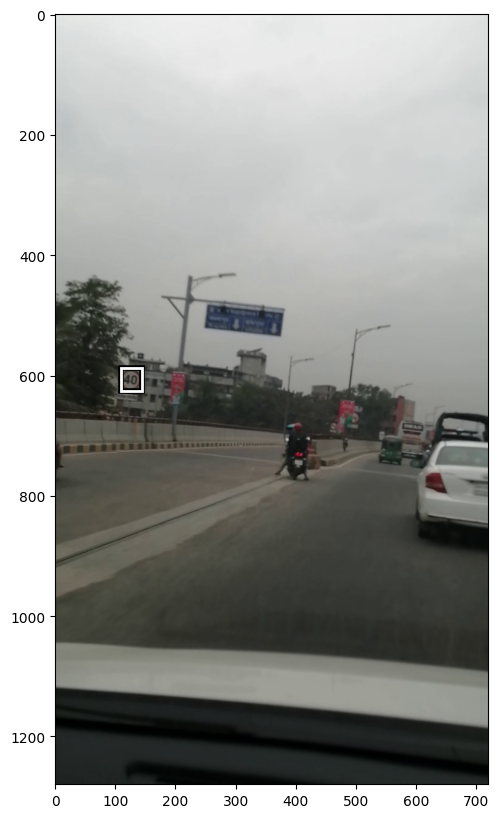

speed limit 40 km/h


In [17]:
traffic_sign_train_ds.show_image(0)

##Creating the Model

In [18]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict

In [19]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[::3]

number of configs: 47


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

In [20]:
import timm
timm.list_models('tf_efficientnetv2_*')

['tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_xl']

In [21]:
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

##Define EfficientDet Dataset

In [22]:
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


def get_train_transforms(target_img_size=1024):
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )


def get_valid_transforms(target_img_size=1024):
    return A.Compose(
        [
            A.Resize(height=target_img_size, width=target_img_size, p=1),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(p=1),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format="pascal_voc", min_area=0, min_visibility=0, label_fields=["labels"]
        ),
    )

class EfficientDetDataset(Dataset):
    def __init__(
        self, dataset_adaptor, transforms=get_valid_transforms()
    ):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        (
            image,
            pascal_bboxes,
            class_labels,
            image_id,
        ) = self.ds.get_image_and_labels_by_idx(index)

        sample = {
            "image": np.array(image, dtype=np.float32),
            "bboxes": pascal_bboxes,
            "labels": class_labels,
        }

        sample = self.transforms(**sample)
        sample["bboxes"] = np.array(sample["bboxes"])
        image = sample["image"]
        pascal_bboxes = sample["bboxes"]
        labels = sample["labels"]

        _, new_h, new_w = image.shape
        sample["bboxes"][:, [0, 1, 2, 3]] = sample["bboxes"][
            :, [1, 0, 3, 2]
        ]  # convert to yxyx

        target = {
            "bboxes": torch.as_tensor(sample["bboxes"], dtype=torch.float32),
            "labels": torch.as_tensor(labels),
            "image_id": torch.tensor([image_id]),
            "img_size": (new_h, new_w),
            "img_scale": torch.tensor([1.0]),
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

##Define the DataModule

In [23]:
from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader

class EfficientDetDataModule(LightningDataModule):

    def __init__(self,
                train_dataset_adaptor,
                validation_dataset_adaptor,
                train_transforms=get_train_transforms(target_img_size=512),
                valid_transforms=get_valid_transforms(target_img_size=512),
                num_workers=4,
                batch_size=8):

        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size
        super().__init__()

    def train_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )

    def train_dataloader(self) -> DataLoader:
        train_dataset = self.train_dataset()
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return train_loader

    def val_dataset(self) -> EfficientDetDataset:
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self) -> DataLoader:
        valid_dataset = self.val_dataset()
        valid_loader = torch.utils.data.DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )

        return valid_loader

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["bboxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

##Define the Training Loop

In [24]:
from numbers import Number
from typing import List
from functools import singledispatch

import numpy as np
import torch

from fastcore.dispatch import typedispatch
from pytorch_lightning import LightningModule


from ensemble_boxes import ensemble_boxes_wbf


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=1,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='tf_efficientnetv2_l',
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms



    def forward(self, images, targets):
        return self.model(images, targets)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.lr)


    def training_step(self, batch, batch_idx):
        images, annotations, _, image_ids = batch

        losses = self.model(images, annotations)

        logging_losses = {
            "class_loss": losses["class_loss"].detach(),
            "box_loss": losses["box_loss"].detach(),
        }

        self.log("train_loss", losses["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)
        self.log(
            "train_class_loss", losses["class_loss"], on_step=True, on_epoch=True, prog_bar=True,
            logger=True
        )
        self.log("train_box_loss", losses["box_loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True)

        return losses['loss']


    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        images, annotations, targets, image_ids = batch
        outputs = self.model(images, annotations)

        detections = outputs["detections"]

        batch_predictions = {
            "predictions": detections,
            "targets": targets,
            "image_ids": image_ids,
        }

        logging_losses = {
            "class_loss": outputs["class_loss"].detach(),
            "box_loss": outputs["box_loss"].detach(),
        }

        self.log("valid_loss", outputs["loss"], on_step=True, on_epoch=True, prog_bar=True,
                 logger=True, sync_dist=True)
        self.log(
            "valid_class_loss", logging_losses["class_loss"], on_step=True, on_epoch=True,
            prog_bar=True, logger=True, sync_dist=True
        )
        self.log("valid_box_loss", logging_losses["box_loss"], on_step=True, on_epoch=True,
                 prog_bar=True, logger=True, sync_dist=True)

        return {'loss': outputs["loss"], 'batch_predictions': batch_predictions}


    @typedispatch
    def predict(self, images: List):
        """
        For making predictions from images
        Args:
            images: a list of PIL images

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        image_sizes = [(image.size[1], image.size[0]) for image in images]
        images_tensor = torch.stack(
            [
                self.inference_tfms(
                    image=np.array(image, dtype=np.float32),
                    labels=np.ones(1),
                    bboxes=np.array([[0, 0, 1, 1]]),
                )["image"]
                for image in images
            ]
        )

        return self._run_inference(images_tensor, image_sizes)

    @typedispatch
    def predict(self, images_tensor: torch.Tensor):
        """
        For making predictions from tensors returned from the model's dataloader
        Args:
            images_tensor: the images tensor returned from the dataloader

        Returns: a tuple of lists containing bboxes, predicted_class_labels, predicted_class_confidences

        """
        if images_tensor.ndim == 3:
            images_tensor = images_tensor.unsqueeze(0)
        if (
            images_tensor.shape[-1] != self.img_size
            or images_tensor.shape[-2] != self.img_size
        ):
            raise ValueError(
                f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})"
            )

        num_images = images_tensor.shape[0]
        image_sizes = [(self.img_size, self.img_size)] * num_images

        return self._run_inference(images_tensor, image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences

    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets

    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

In [25]:
dm = EfficientDetDataModule(train_dataset_adaptor=traffic_sign_train_ds,
        validation_dataset_adaptor=traffic_sign_train_ds,
        num_workers=4,
        batch_size=2)

In [29]:
model = EfficientDetModel(
    num_classes=15,
    img_size=512
    )

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 15, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''

model.safetensors:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [26]:
from pytorch_lightning import Trainer

In [31]:
trainer = Trainer(
          max_epochs=20, num_sanity_val_steps=1,
   )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
#Train for the first time
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | DetBenchTrain | 116 M  | train
------------------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.664   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
torch.save(model.state_dict(), 'trained_effdet')

In [ ]:
import shutil

source_file = '/content/trained_effdet'
#destination_folder = '/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/EfficientDet'
destination_folder = '/content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model'
shutil.copy(source_file, destination_folder)

print(f"File copied from {source_file} to {destination_folder}")

File copied from /content/trained_effdet to /content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model


In [ ]:
import shutil
import os

# Define the source folder and the destination folder
source_folder = '/content/lightning_logs'
destination_folder = '/content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model'

# Ensure the destination folder exists
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Define the new folder path inside the destination folder
new_folder_path = os.path.join(destination_folder, os.path.basename(source_folder))

# Copy the source folder to the new folder path
shutil.copytree(source_folder, new_folder_path)

print(f'Folder copied from {source_folder} to {new_folder_path}')


In [32]:
model = EfficientDetModel(
    num_classes=15,
    img_size=512
    )

#model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model/trained_effdet'))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/EfficientDet/trained_effdet'))

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 15, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''

<All keys matched successfully>

##Re training the saved model

In [33]:
#Train from saved model
trainer.fit(model, dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | DetBenchTrain | 116 M  | train
------------------------------------------------
116 M     Trainable params
0         Non-trainable params
116 M     Total params
467.664   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/pytorc

Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [34]:
#Second time running
torch.save(model.state_dict(), 'trained_effdet')

In [27]:
import shutil

source_file = '/content/trained_effdet'
destination_folder = '/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/EfficientDet'
#destination_folder = '/content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model'
shutil.copy(source_file, destination_folder)

print(f"File copied from {source_file} to {destination_folder}")

File copied from /content/trained_effdet to /content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/EfficientDet


In [28]:
import shutil
import os

# Define the source folder and the destination folder
source_folder = '/content/lightning_logs'
#destination_folder = '/content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model'

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Define the new folder path inside the destination folder
new_folder_path = os.path.join(destination_folder, os.path.basename(source_folder))

# Check if the new folder path exists and remove it if it does
if os.path.exists(new_folder_path):
    shutil.rmtree(new_folder_path)

# Copy the source folder to the new folder path
shutil.copytree(source_folder, new_folder_path)

print(f'Folder copied from {source_folder} to {new_folder_path}')

Folder copied from /content/lightning_logs to /content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/EfficientDet/lightning_logs


In [29]:
model = EfficientDetModel(
    num_classes=15,
    img_size=512
    )

#model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dataset- -Conference/EfficientDet_Model/trained_effdet'))
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dataset- -Conference/Dataset- -Conference/EfficientDet/trained_effdet'))

{'name': 'tf_efficientnetv2_l', 'backbone_name': 'tf_efficientnetv2_l', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 15, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url': ''

<All keys matched successfully>

##Continue Futher

In [30]:
model.eval()

EfficientDetModel(
  (model): DetBenchTrain(
    (model): EfficientDet(
      (backbone): EfficientNetFeatures(
        (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (blocks): Sequential(
          (0): Sequential(
            (0): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn1): BatchNormAct2d(
                32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): SiLU(inplace=True)
              )
              (aa): Identity()
              (drop_path): Identity()
            )
            (1): ConvBnAct(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [31]:
image1, truth_bboxes1, _, _ = traffic_sign_train_ds.get_image_and_labels_by_idx(92)
image2, truth_bboxes2, _, _ = traffic_sign_train_ds.get_image_and_labels_by_idx(83)

In [32]:
images = [image1, image2]

In [33]:
predicted_bboxes, predicted_class_labels, predicted_class_confidences = model.predict(images)

In [34]:
def compare_bboxes_for_image(
    image,
    predicted_bboxes,
    actual_bboxes,
    draw_bboxes_fn=draw_pascal_voc_bboxes,
    figsize=(20, 20),
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(image)
    ax1.set_title("Prediction")
    ax2.imshow(image)
    ax2.set_title("Actual")

    draw_bboxes_fn(ax1, predicted_bboxes)
    draw_bboxes_fn(ax2, actual_bboxes)
    plt.show()

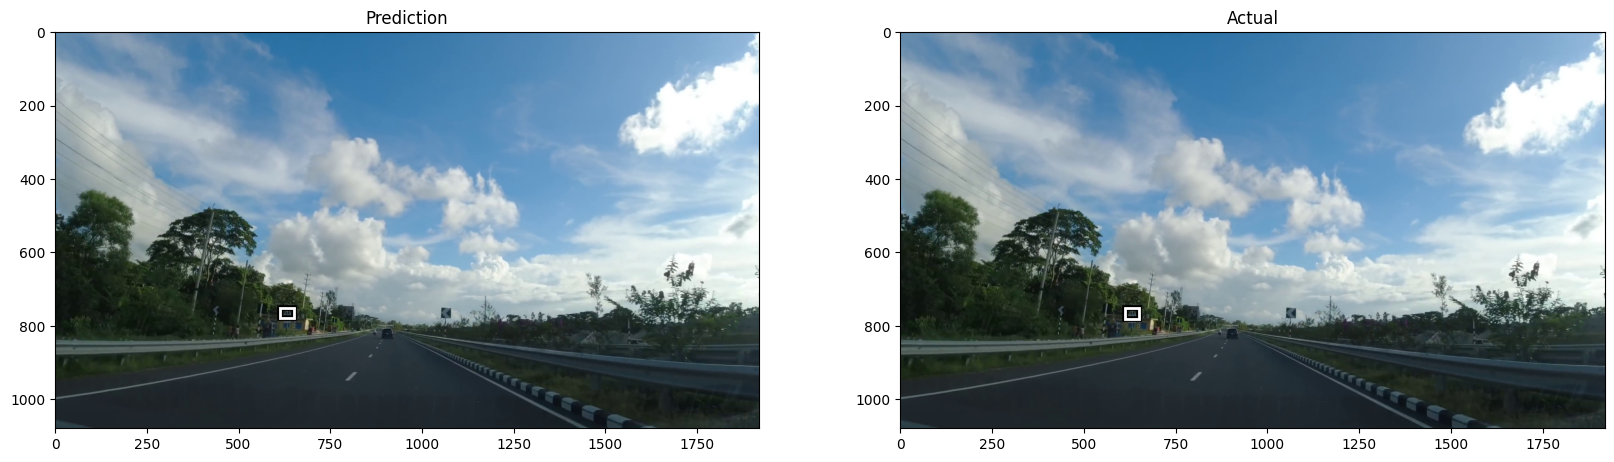

School


In [35]:
compare_bboxes_for_image(image1, predicted_bboxes=predicted_bboxes[0], actual_bboxes=truth_bboxes1.tolist())
class_label = int(predicted_class_labels[0][0])
print(get_class_name(class_label))

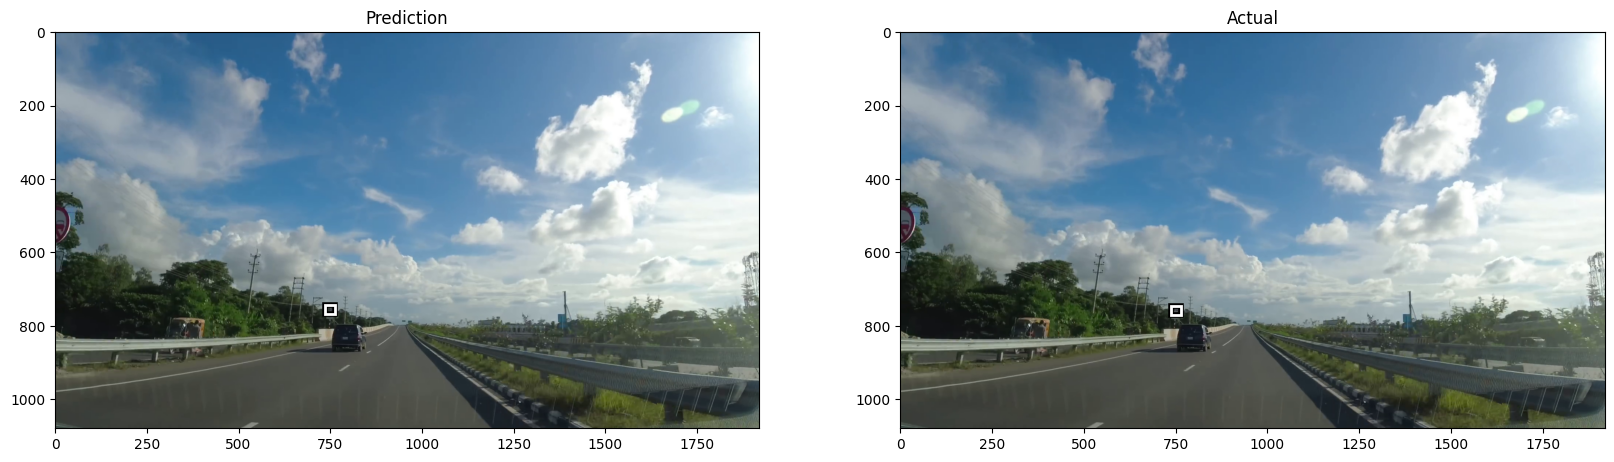

speed limit 80 km/h


In [36]:
compare_bboxes_for_image(image2, predicted_bboxes=predicted_bboxes[1], actual_bboxes=truth_bboxes2.tolist())
class_label = int(predicted_class_labels[1][0])
print(get_class_name(class_label))

In [37]:
loader = dm.val_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [38]:
dl_iter = iter(loader)

In [39]:
batch = next(dl_iter)

In [40]:
device = model.device
device

device(type='cpu')

In [41]:
output = model.validation_step(batch=batch, batch_idx=0)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [42]:
output

{'loss': tensor(0.0158),
 'batch_predictions': {'predictions': tensor([[[7.5529e+01, 2.3518e+02, 1.0206e+02, 2.5074e+02, 8.5060e-01,
            5.0000e+00],
           [6.2766e+01, 2.3592e+02, 9.3047e+01, 2.5189e+02, 7.1015e-02,
            5.0000e+00],
           [7.2018e+01, 2.2925e+02, 1.0179e+02, 2.4605e+02, 3.5087e-02,
            5.0000e+00],
           ...,
           [2.5765e+01, 3.6995e+02, 1.1268e+02, 5.0798e+02, 3.0079e-03,
            1.0000e+00],
           [4.9441e+02, 3.6035e+01, 5.1200e+02, 6.2845e+01, 3.0006e-03,
            9.0000e+00],
           [2.8067e+02, 2.2855e+02, 3.1337e+02, 2.4576e+02, 2.9913e-03,
            5.0000e+00]],
  
          [[1.7972e+02, 3.2483e+02, 1.9160e+02, 3.4617e+02, 9.5121e-01,
            5.0000e+00],
           [1.9951e+02, 3.3074e+02, 2.1073e+02, 3.4999e+02, 1.5419e-02,
            5.0000e+00],
           [1.7972e+02, 3.2483e+02, 1.9160e+02, 3.4617e+02, 1.2399e-02,
            9.0000e+00],
           ...,
           [0.0000e+00, 0.0000

In [43]:
from fastcore.basics import patch

@patch
def aggregate_prediction_outputs(self: EfficientDetModel, outputs):

    detections = torch.cat(
        [output["batch_predictions"]["predictions"] for output in outputs]
    )

    image_ids = []
    targets = []
    for output in outputs:
        batch_predictions = output["batch_predictions"]
        image_ids.extend(batch_predictions["image_ids"])
        targets.extend(batch_predictions["targets"])

    (
        predicted_bboxes,
        predicted_class_confidences,
        predicted_class_labels,
    ) = self.post_process_detections(detections)

    return (
        predicted_class_labels,
        image_ids,
        predicted_bboxes,
        predicted_class_confidences,
        targets,
    )

In [44]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [45]:
!pip install git+https://github.com/alexhock/object-detection-metrics

  Cloning https://github.com/alexhock/object-detection-metrics to /tmp/pip-req-build-zqbriufd
  Running command git clone --filter=blob:none --quiet https://github.com/alexhock/object-detection-metrics /tmp/pip-req-build-zqbriufd
  Resolved https://github.com/alexhock/object-detection-metrics to commit 4ba0cfa7677f8f0b65776567b6ccb7b45ac3b1e0
  Preparing metadata (setup.py) ... done


In [46]:
from objdetecteval.metrics.coco_metrics import get_coco_stats

In [47]:
@patch
def validation_epoch_end(self: EfficientDetModel, outputs):
    """Compute and log training loss and accuracy at the epoch level."""

    validation_loss_mean = torch.stack(
        [output["loss"] for output in outputs]
    ).mean()

    (
        predicted_class_labels,
        image_ids,
        predicted_bboxes,
        predicted_class_confidences,
        targets,
    ) = self.aggregate_prediction_outputs(outputs)

    truth_image_ids = [target["image_id"].detach().item() for target in targets]
    truth_boxes = [
        target["bboxes"].detach()[:, [1, 0, 3, 2]].tolist() for target in targets
    ] # convert to xyxy for evaluation
    truth_labels = [target["labels"].detach().tolist() for target in targets]

    stats = get_coco_stats(
        prediction_image_ids=image_ids,
        predicted_class_confidences=predicted_class_confidences,
        predicted_bboxes=predicted_bboxes,
        predicted_class_labels=predicted_class_labels,
        target_image_ids=truth_image_ids,
        target_bboxes=truth_boxes,
        target_class_labels=truth_labels,
    )['All']

    return {"val_loss": validation_loss_mean, "metrics": stats}

In [48]:
model.validation_epoch_end([output])

creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.725
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.725
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.750
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.750
 Average Recall     (AR) @[ IoU=0

{'val_loss': tensor(0.0158),
 'metrics': {'AP_all': 0.7252475247524752,
  'AP_all_IOU_0_50': 1.0,
  'AP_all_IOU_0_75': 1.0,
  'AP_small': 0.7252475247524752,
  'AP_medium': -1.0,
  'AP_large': -1.0,
  'AR_all_dets_1': 0.75,
  'AR_all_dets_10': 0.75,
  'AR_all': 0.75,
  'AR_small': 0.75,
  'AR_medium': -1.0,
  'AR_large': -1.0}}

In [49]:
images, annotations,targets, image_ids = batch

In [50]:
predicted_bboxes, predicted_class_labels, predicted_class_confidences = model.predict(images)

In [51]:
image, _, _, _ = traffic_sign_train_ds.get_image_and_labels_by_idx(1)

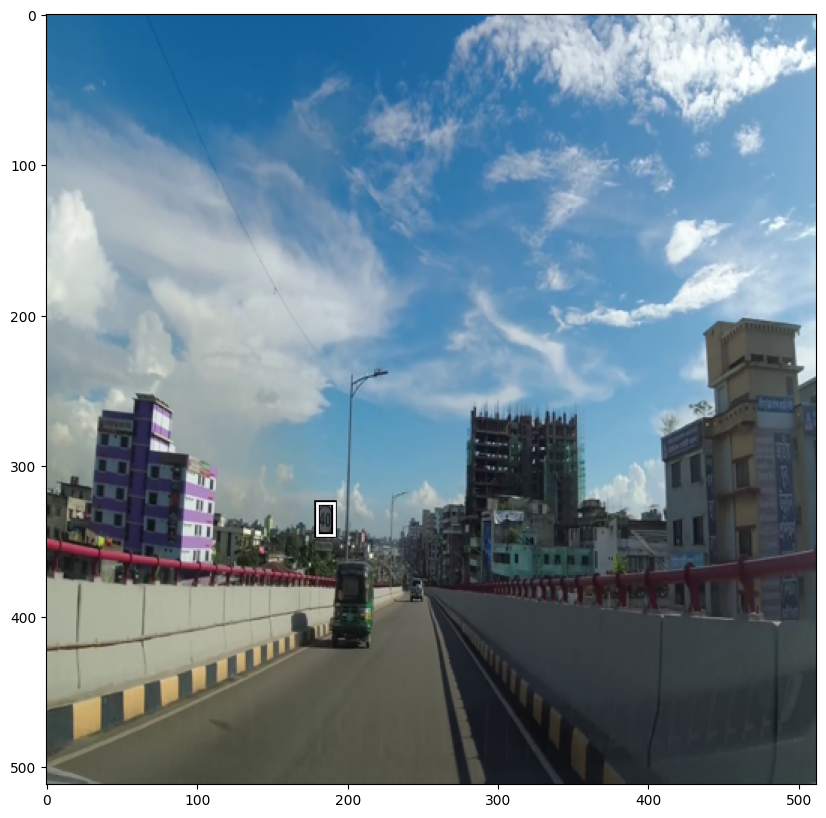

speed limit 40 km/h


In [52]:
show_image(image.resize((512, 512)), predicted_bboxes[1])
class_label = int(predicted_class_labels[1][0])
print(get_class_name(class_label))

In [1]:
import os
import subprocess

# Define the folder path
folder_path = "/content/lightning_logs"

# Step 1: Check if the folder exists
if not os.path.exists(folder_path):
    print(f"Folder {folder_path} does not exist.")
else:
    try:
        # Configure Git user details
        subprocess.run(["git", "config", "--global", "user.email", "*********"], check=True, capture_output=True, text=True)
        subprocess.run(["git", "config", "--global", "user.name", "******"], check=True, capture_output=True, text=True)

        # Step 2: Initialize a Git repository (if not already initialized)
        if not os.path.exists(".git"):
            result = subprocess.run(["git", "init"], check=True, capture_output=True, text=True)
            print(result.stdout)

        # Step 3: Add the folder to the repository
        result = subprocess.run(["git", "add", folder_path], check=True, capture_output=True, text=True)
        print(result.stdout)

        # Step 4: Commit the changes
        result = subprocess.run(["git", "commit", "-m", "Add Efficient lightning_logs folder"], check=True, capture_output=True, text=True)
        print(result.stdout)

        # Step 5: Push to GitHub
        github_url = "https://github.com/Samin-Sadaf7/Image_works.git"
        branch = "main"

        # Check if the remote "origin" exists
        result = subprocess.run(["git", "remote", "get-url", "origin"], check=False, capture_output=True, text=True)
        if result.returncode != 0:  # Remote "origin" does not exist
            result = subprocess.run(["git", "remote", "add", "origin", github_url], check=True, capture_output=True, text=True)
            print(result.stdout)

        result = subprocess.run(["git", "branch", "-M", branch], check=True, capture_output=True, text=True)
        print(result.stdout)
        result = subprocess.run(["git", "push", "-u", "origin", branch], check=True, capture_output=True, text=True)
        print(result.stdout)

    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e.stderr}")

Folder /content/lightning_logs does not exist.
